In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import acf, pacf
!pip install keras-tuner
import keras_tuner as kt
import random
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
df = pd.read_csv('AP003.csv')
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


## A. EDA

In [ ]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
count,44691.000000,45018.000000,46252.000000,45705.000000,47040.000000,45756.000000,43604.000000,46993.000000,45309.000000,46678.000000,...,46335.000000,46520.000000,46522.000000,44710.000000,47045.000000,43680.000000,47043.000000,46370.000000,47148.000000,46658.000000
mean,46.869591,111.938589,14.817678,34.921808,29.857413,13.813287,12.323789,0.666865,29.118732,3.309707,...,29.408316,73.166650,1.895205,209.078558,127.619004,746.903387,0.017120,27.591552,0.022934,2.649006
std,35.201161,74.285923,22.372042,23.912796,27.042412,14.685377,10.266289,0.550187,29.388645,2.926522,...,3.228845,8.592562,1.199727,67.168061,175.790733,7.656193,0.071902,4.426638,0.282441,8.785483
min,0.250000,1.000000,0.030000,0.030000,0.000000,0.020000,0.030000,0.000000,0.100000,0.000000,...,6.700000,15.750000,0.100000,7.000000,0.000000,700.000000,-0.550000,5.180000,0.000000,0.000000
25%,23.415000,63.330000,2.915000,18.400000,12.670000,7.050000,6.350000,0.330000,9.930000,1.500000,...,27.900000,68.000000,0.880000,157.250000,6.250000,743.000000,0.000000,24.830000,0.000000,0.570000
50%,38.750000,97.750000,6.600000,30.300000,22.910000,11.600000,10.680000,0.590000,17.570000,2.700000,...,28.850000,74.330000,1.800000,220.000000,8.250000,747.500000,0.000000,27.650000,0.000000,1.300000
75%,62.330000,137.500000,17.300000,43.900000,36.930000,16.770000,15.520000,0.890000,37.680000,4.380000,...,30.180000,79.670000,2.730000,262.670000,227.500000,751.000000,0.050000,30.400000,0.000000,2.770000
max,840.000000,904.000000,419.780000,420.200000,408.250000,454.900000,194.250000,11.280000,199.300000,91.000000,...,59.880000,92.000000,7.970000,360.000000,730.000000,770.000000,1.680000,48.500000,12.500000,410.850000


In [ ]:
pd.to_datetime(df['From Date']).describe()

,From Date
count,50400
mean,2020-05-15 23:30:00
min,2017-07-01 00:00:00
25%,2018-12-07 23:45:00
50%,2020-05-15 23:30:00
75%,2021-10-22 23:15:00
max,2023-03-31 23:00:00


In [ ]:
pd.to_datetime(df['To Date']).describe()

,To Date
count,50400
mean,2020-05-16 00:30:00
min,2017-07-01 01:00:00
25%,2018-12-08 00:45:00
50%,2020-05-16 00:30:00
75%,2021-10-23 00:15:00
max,2023-04-01 00:00:00


In [ ]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['To Date'] = pd.to_datetime(df['To Date'])
time_diff = (df['To Date'] - df['From Date']).dt.total_seconds()
display(time_diff.describe())

,0
count,50400.0
mean,3600.0
std,0.0
min,3600.0
25%,3600.0
50%,3600.0
75%,3600.0
max,3600.0


Kolom From Date dan To Date menunjukkan perbedaan waktu yang selalu 3600 detik (1 jam), yang mengonfirmasi bahwa data ini bersifat per jam (hourly).

In [ ]:
numerical = []

for i in df.columns:
    if "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        numerical.append(i)

print(numerical)

['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']


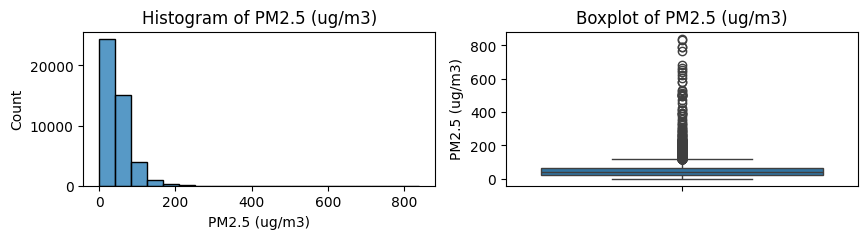

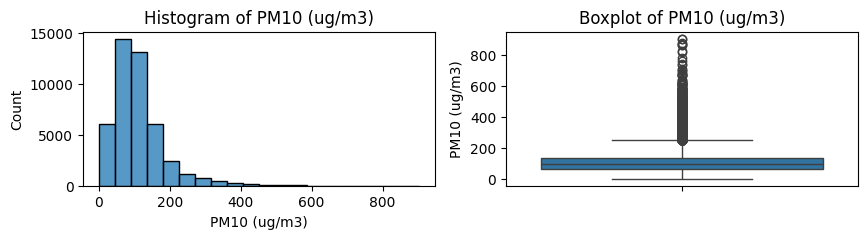

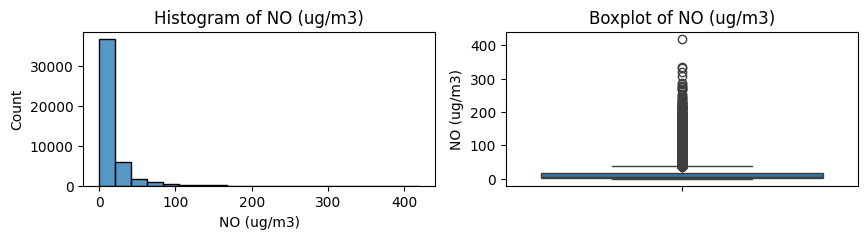

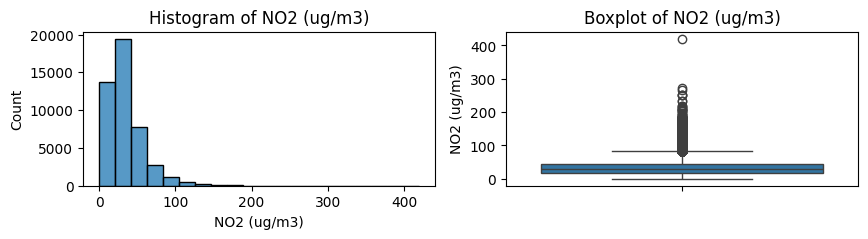

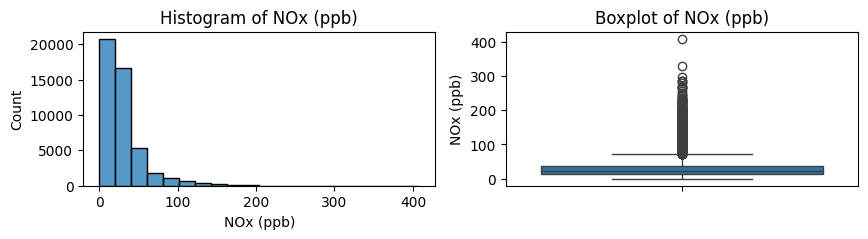

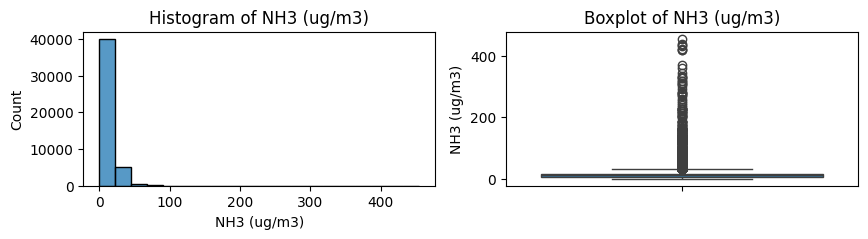

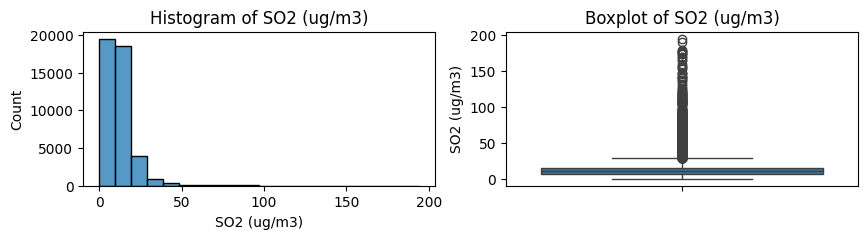

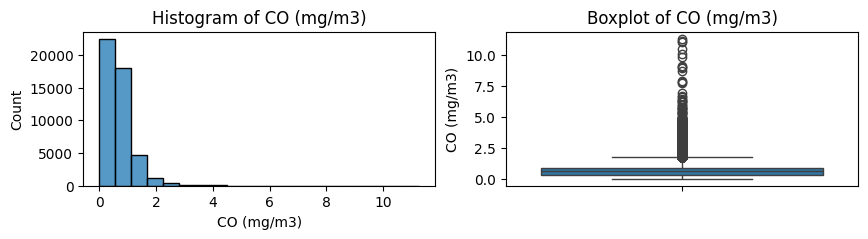

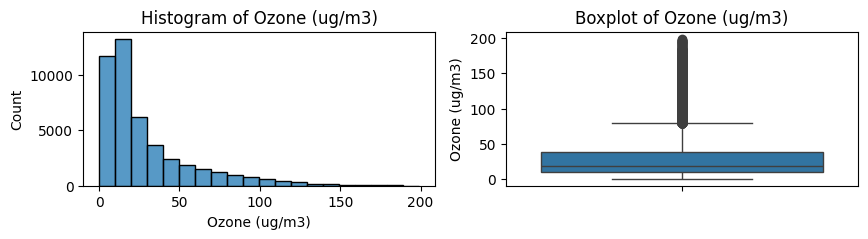

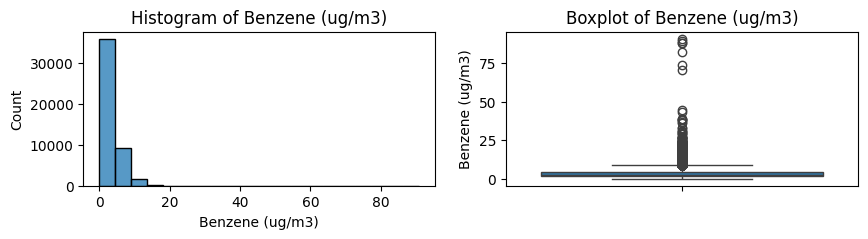

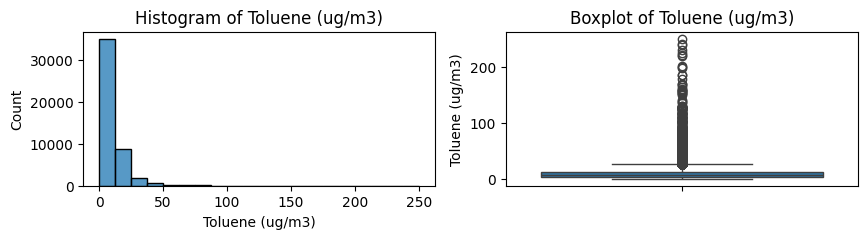

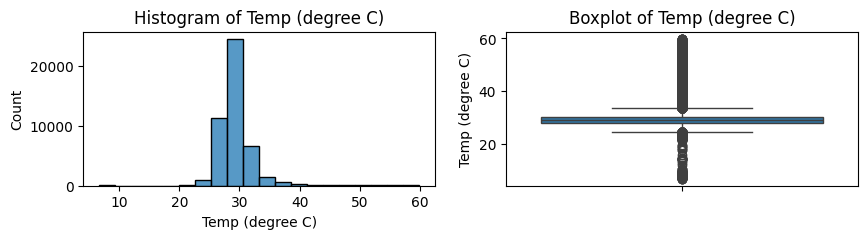

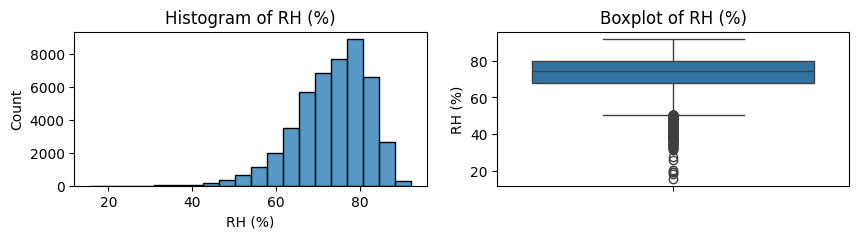

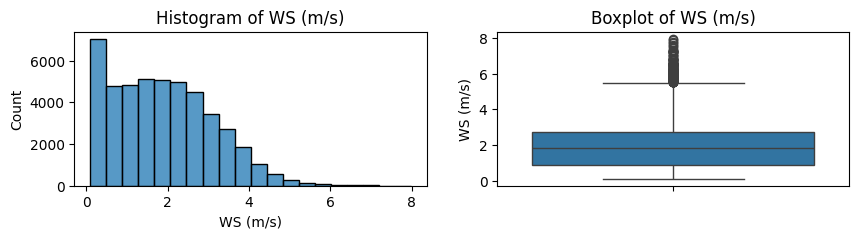

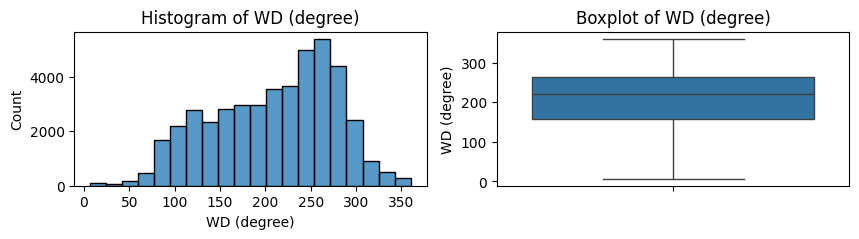

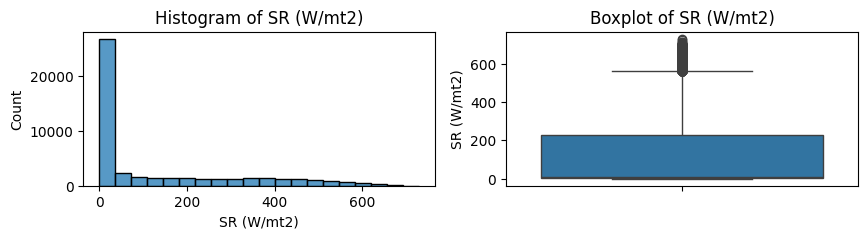

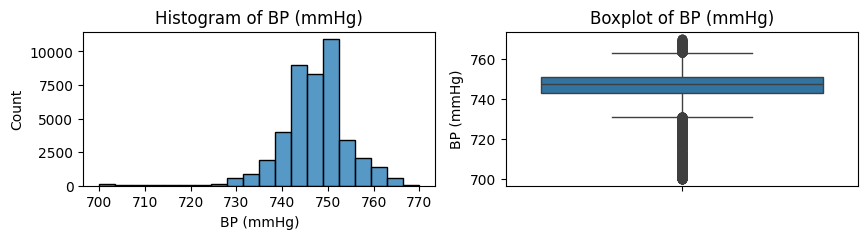

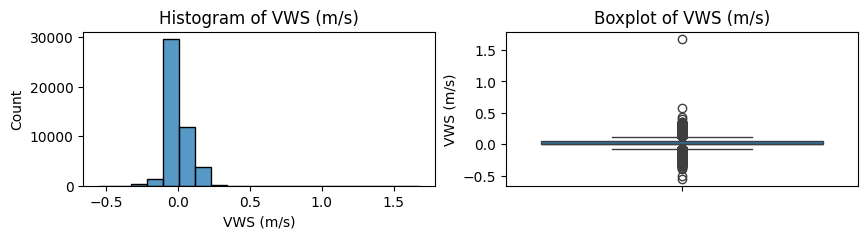

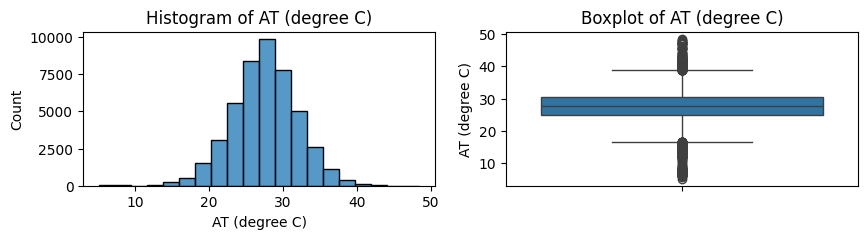

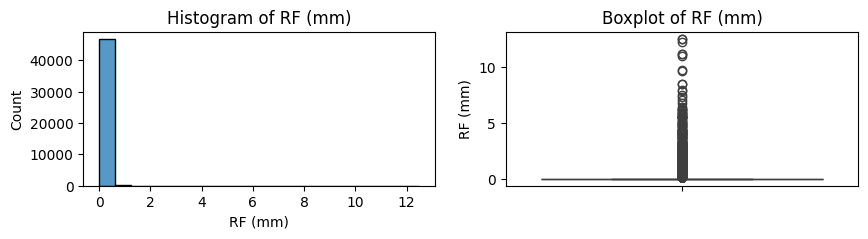

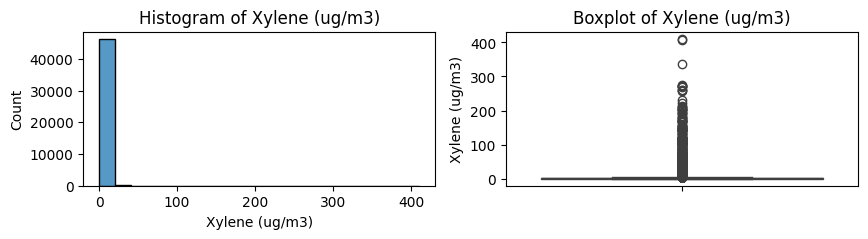

In [ ]:
def check_dist(df, column):
    for i in column:
        plt.figure(figsize=(10,2))
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=20)
        plt.title(f'Histogram of {i}')

        plt.subplot(1,2,2)
        sns.boxplot(y=df[i])
        plt.title(f'Boxplot of {i}')
        plt.show()

check_dist(df[numerical], numerical)

Dari hasil histogram dan boxplot, dapat disimpulkan bahwa mayoritas data suhu terpusat di sekitar 20-30°C, dengan frekuensi tertinggi pada kisaran tersebut. Namun, terdapat beberapa outliers yang cukup tinggi, yang terlihat pada boxplot, menunjukkan adanya nilai suhu yang jauh lebih tinggi dibandingkan dengan data lainnya. Ini menandakan bahwa data suhu memiliki variasi yang lebar, dan adanya outliers perlu dipertimbangkan dalam proses data preprocessing agar tidak mempengaruhi model secara negatif (misalnya menggunakan robust scaler yang lebih tahan terhadap outliers).

In [ ]:
df.isnull().sum()

,0
From Date,0
To Date,0
PM2.5 (ug/m3),5709
PM10 (ug/m3),5382
NO (ug/m3),4148
NO2 (ug/m3),4695
NOx (ppb),3360
NH3 (ug/m3),4644
SO2 (ug/m3),6796
CO (mg/m3),3407


Untuk menangani missing values, saya menggunakan forward fill (ffill) dam backfill di semua kolom. Metode ini cocok karena data kita bersifat time-series, di mana nilai suatu waktu biasanya mirip dengan nilai sebelumnya. Contohnya, kolom seperti PM2.5, NO2, dan Temp/AT biasanya tidak berubah drastis dalam waktu singkat, sehingga bisa diisid dengan nilai yang paling dekat sebelumnya.


In [ ]:
df = df.ffill()
df = df.bfill()
df.isnull().sum()

,0
From Date,0
To Date,0
PM2.5 (ug/m3),0
PM10 (ug/m3),0
NO (ug/m3),0
NO2 (ug/m3),0
NOx (ppb),0
NH3 (ug/m3),0
SO2 (ug/m3),0
CO (mg/m3),0


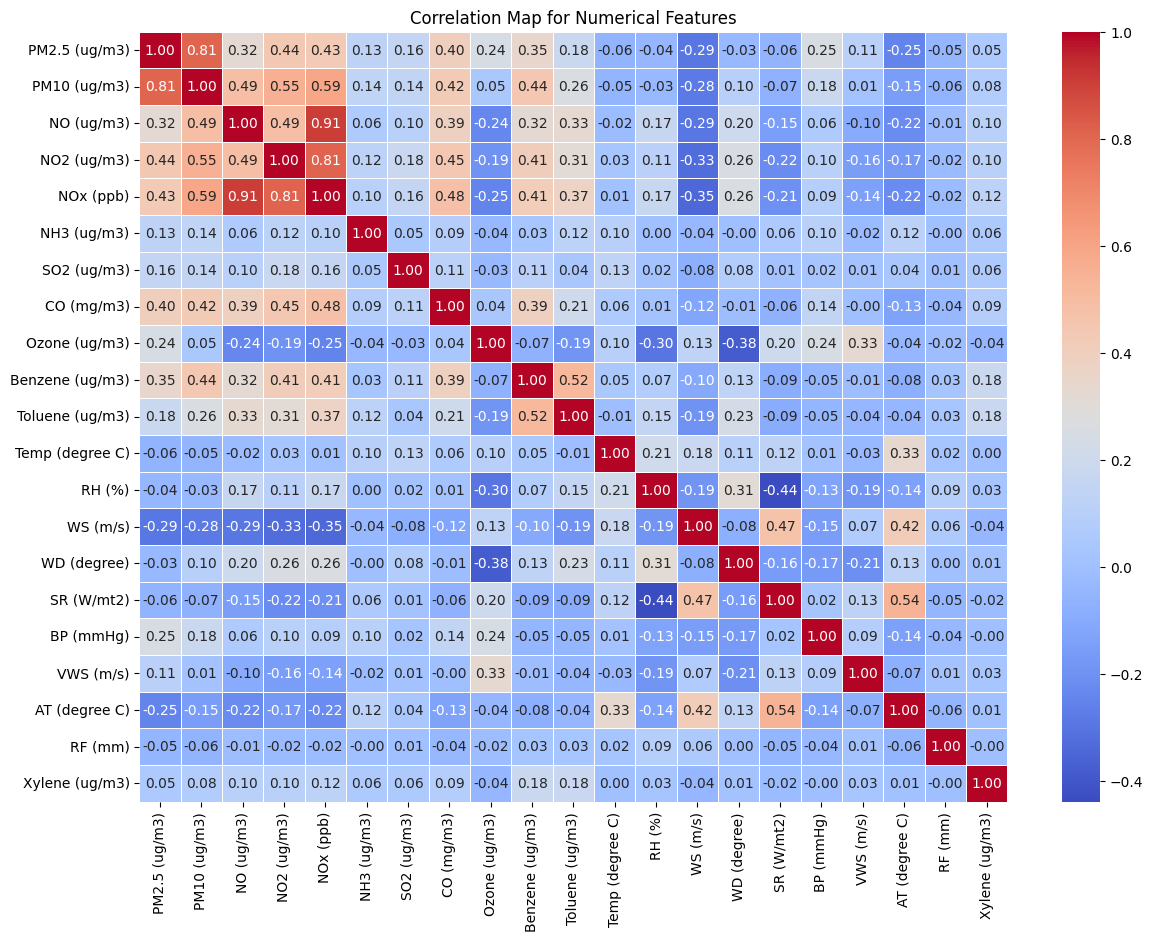

In [ ]:
plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Map for Numerical Features')
plt.show()

Berdasarkan correlation map, terdapat beberapa fitur yang sangat berkorelasi satu sama lain, seperti PM2.5 dan PM10, dengan korelasi 0.81, serta NO dan NO2, yang memiliki korelasi tinggi dengan NOx. Dalam hal ini, NOx merupakan gabungan dari NO dan NO2, sehingga memiliki informasi yang redundan dengan kedua fitur tersebut. Oleh karena itu, untuk mengurangi redundansi dan meningkatkan efisiensi model, kolom-kolom seperti NO, NO2, serta PM10 yang sangat berkorelasi dengan PM2.5, dipilih untuk di-drop.

Dengan menghapus fitur-fitur yang saling terkait erat, kita dapat mempercepat proses pelatihan model dan menghindari masalah multikolinearitas yang dapat memengaruhi kualitas prediksi. Selain itu, Temp juga di-drop karena korelasinya yang rendah dengan variabel target AT dan fitur lainnya. Penghapusan kolom redundan ini bertujuan untuk meningkatkan kinerja model dan memfokuskan pada fitur yang lebih relevan.

In [ ]:
df.drop(['Temp (degree C)', 'NO (ug/m3)',
       'NO2 (ug/m3)', 'VWS (m/s)',  'PM10 (ug/m3)' ], axis=1, inplace=True)

In [ ]:
numerical.remove('Temp (degree C)')
numerical.remove('NO (ug/m3)')
numerical.remove('NO2 (ug/m3)')
numerical.remove('VWS (m/s)')
numerical.remove('PM10 (ug/m3)')
numerical

['PM2.5 (ug/m3)',
 'NOx (ppb)',
 'NH3 (ug/m3)',
 'SO2 (ug/m3)',
 'CO (mg/m3)',
 'Ozone (ug/m3)',
 'Benzene (ug/m3)',
 'Toluene (ug/m3)',
 'RH (%)',
 'WS (m/s)',
 'WD (degree)',
 'SR (W/mt2)',
 'BP (mmHg)',
 'AT (degree C)',
 'RF (mm)',
 'Xylene (ug/m3)']

In [ ]:
numerical.remove('AT (degree C)')

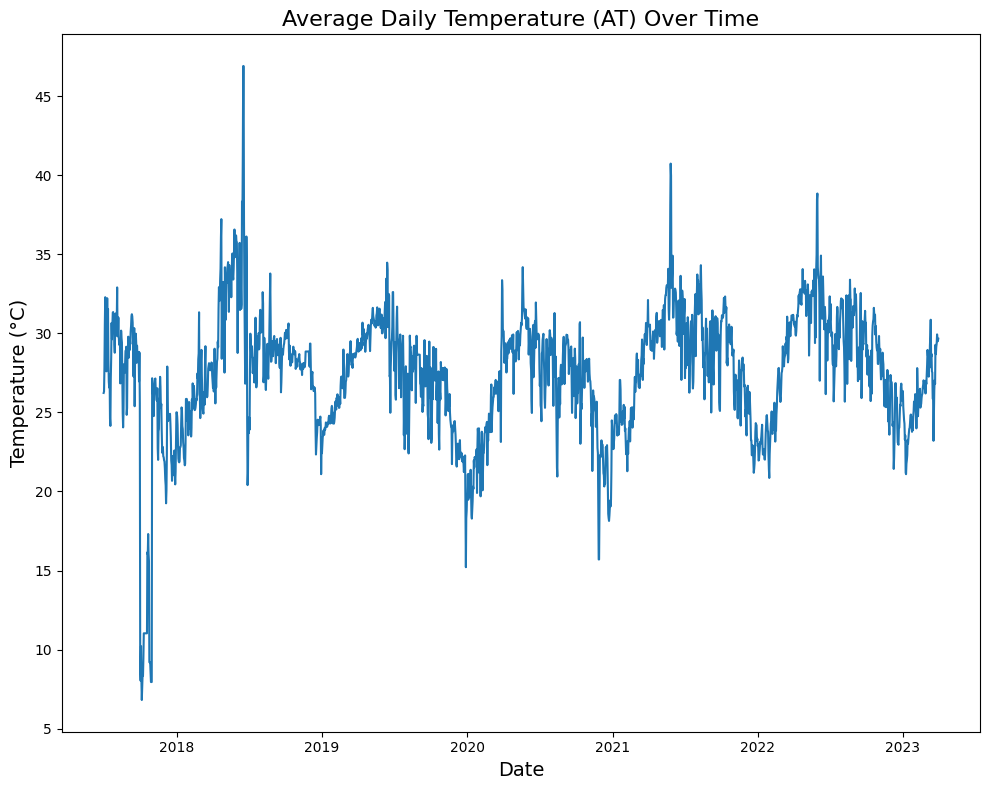

In [ ]:
df_daily = df.resample('D', on='From Date').mean()
timesteps_daily = df_daily.index
at_values_daily = df_daily['AT (degree C)']

plt.figure(figsize=(10, 8))
plt.plot(timesteps_daily, at_values_daily, color='tab:blue')
plt.title("Average Daily Temperature (AT) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.tight_layout()
plt.show()

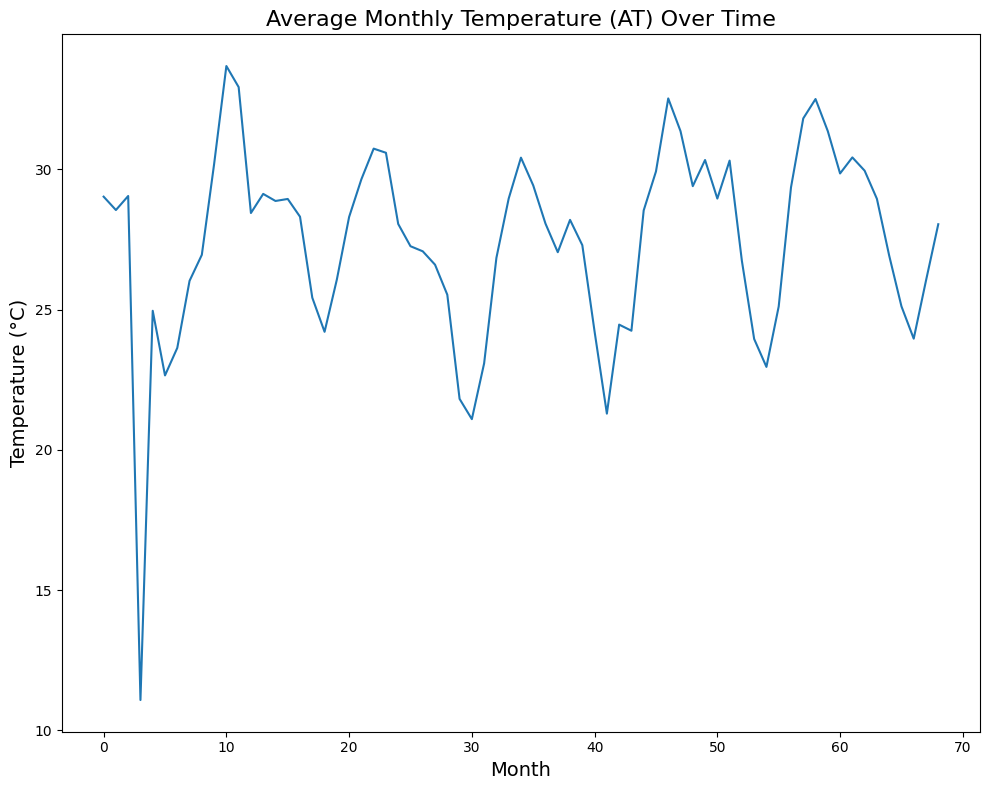

In [ ]:
df_monthly = df.resample('M', on='From Date').mean()
df_monthly.reset_index(inplace=True)
timesteps_monthly = df_monthly.index
at_values_monthly = df_monthly['AT (degree C)']

plt.figure(figsize=(10,8))
plt.plot(timesteps_monthly, at_values_monthly, color='tab:blue')
plt.title("Average Monthly Temperature (AT) Over Time", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.tight_layout()
plt.show()


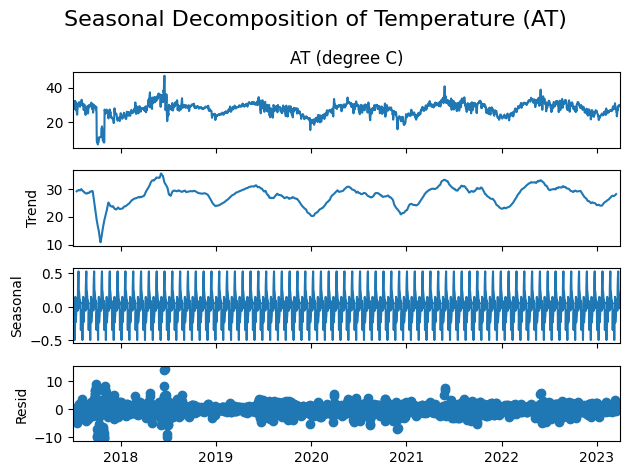

In [ ]:
result = seasonal_decompose(df_daily['AT (degree C)'], model='additive', period=30)
result.plot()
plt.suptitle('Seasonal Decomposition of Temperature (AT)', fontsize=16)
plt.tight_layout()
plt.show()

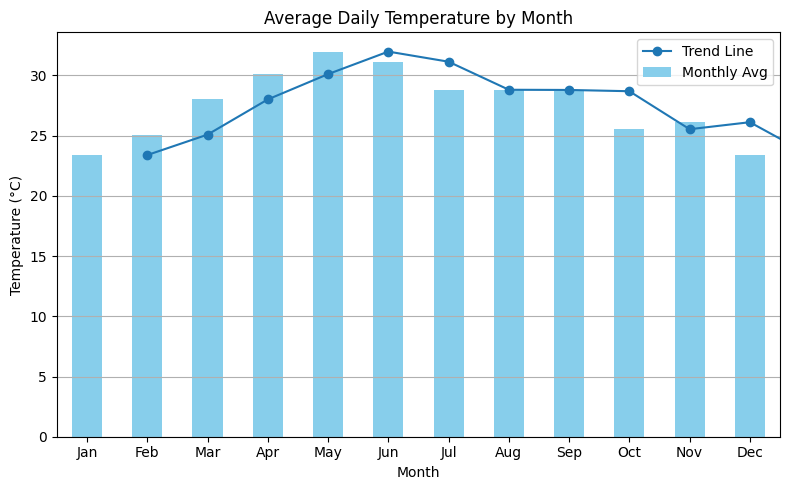

In [ ]:
df_daily['month'] = df_daily.index.month
monthly_avg = df_daily.groupby('month')['AT (degree C)'].mean()

plt.figure(figsize=(8, 5))
ax = monthly_avg.plot(kind='bar', color='skyblue', label='Monthly Avg', legend=True)
monthly_avg.plot(kind='line', marker='o', label='Trend Line', ax=ax)

plt.title("Average Daily Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


Dari hasil seasonal decomposition, kita dapat mengidentifikasi bahwa suhu tertinggi terjadi pada bulan Mei hingga Juni, dengan suhu yang cenderung stabil di kisaran 30°C keatas. Hal ini menunjukkan adanya puncak suhu yang konsisten setiap tahunnya pada periode tersebut yang biasanya merupakan musim panas. Sebaliknya, suhu terendah tercatat pada bulan Desember hingga Januari, dengan nilai yang lebih rendah, berkisar antara 20-25°C. Pola musiman ini mengindikasikan adanya siklus tahunan yang jelas dalam fluktuasi temperatur.  

Informasi ini penting untuk diketahui sebelum membangun model time series, karena keberadaan pola musiman dan tren tahunan bisa memengaruhi akurasi prediksi, terutama dalam konteks multivariat dan jangka pendek seperti memprediksi 1 jam ke depan. Dengan memahami bahwa suhu memiliki siklus musiman tahunan, saya dapat memastikan bahwa proses training model tidak mengabaikan komponen musiman yang penting ini. Selain itu, pola musiman ini menjadi indikator bahwa data kita tidak stasioner secara musiman, sehingga perlu diperhatikan dalam pemilihan input dan preprocessing.


## B. Preprocessing

In [ ]:
val_size, test_size = 0.1, 0.1
total_size = len(df)

train_size = int(total_size * (1 - val_size - test_size))
val_size = int(total_size * val_size)
test_size = int(total_size * test_size)

df_train = df[:train_size]
df_val = df[train_size:train_size+val_size]
df_test = df[train_size+val_size:]

print(f"Train size: {df_train.shape[0]} rows")
print(f"Validation size: {df_val.shape[0]} rows")
print(f"Test size: {df_test.shape[0]} rows")
print(f"Total rows: {df_train.shape[0] + df_val.shape[0] + df_test.shape[0]} rows")


Train size: 40320 rows
Validation size: 5040 rows
Test size: 5040 rows
Total rows: 50400 rows


Saya membagi dataset menjadi tiga bagian utama sesuai dengan ketentuan: 80% untuk training, 10% untuk validasi, dan 10% untuk testing. Dari total 50.400 data, pembagian ini menghasilkan 40.320 data untuk train, 5.040 data untuk validasi, dan 5.040 data untuk testing. Pembagian dilakukan secara berurutan (tanpa shuffle) karena sifat data ini adalah time series, sehingga urutan waktu harus tetap dipertahankan agar model bisa belajar pola temporal dengan benar.

In [ ]:
numerical

['PM2.5 (ug/m3)',
 'NOx (ppb)',
 'NH3 (ug/m3)',
 'SO2 (ug/m3)',
 'CO (mg/m3)',
 'Ozone (ug/m3)',
 'Benzene (ug/m3)',
 'Toluene (ug/m3)',
 'RH (%)',
 'WS (m/s)',
 'WD (degree)',
 'SR (W/mt2)',
 'BP (mmHg)',
 'RF (mm)',
 'Xylene (ug/m3)']

In [ ]:
scaler = RobustScaler()
df_train['AT (degree C)'] = scaler.fit_transform(df_train[['AT (degree C)']])
df_val['AT (degree C)'] = scaler.transform(df_val[['AT (degree C)']])
df_test['AT (degree C)'] = scaler.transform(df_test[['AT (degree C)']])

scaler2 = RobustScaler()
df_train[numerical] = scaler2.fit_transform(df_train[numerical])
df_val[numerical] = scaler2.transform(df_val[numerical])
df_test[numerical] = scaler2.transform(df_test[numerical])

Di sini saya melakukan scaling pada data menggunakan RobustScaler untuk mengurangi pengaruh outliers dan menstabilkan distribusi data. Untuk kolom temperatur (AT), saya menerapkan fit transform di data training dan transform saja pada validation dan testing. Selain itu, saya juga melakukan scaling pada kolom numerik lainnya untuk memastikan semua fitur numerik berada dalam skala yang seragam, yang membantu meningkatkan kinerja model.

In [ ]:
df_train = df_train.drop(columns=['From Date', 'To Date'])
df_val = df_val.drop(columns=['From Date', 'To Date'])
df_test = df_test.drop(columns=['From Date', 'To Date'])
df_train.head()

,PM2.5 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),AT (degree C),RF (mm),Xylene (ug/m3)
0,0.324872,-0.159261,-1.104639,1.594595,1.296296,3.753814,-0.780645,-0.734104,0.787234,-0.183333,0.659483,-0.005593,-1.0,-0.200000,0.00,-0.352697
1,-0.168718,-0.426749,-1.104639,-0.148108,2.111111,3.753814,-0.822581,-0.782659,0.893617,0.277778,0.780172,-0.005593,-1.1,-0.432143,1.50,-0.414938
2,-0.168718,-0.808183,-1.097087,0.126486,1.055556,3.753814,-0.796774,-0.766474,1.021277,-0.683333,0.660948,-0.005951,-1.1,-0.580357,0.33,-0.443983
3,-0.752051,-0.695117,-1.097087,1.100541,1.759259,3.753814,-0.725806,-0.765318,1.021277,-0.250000,0.806034,-0.008949,-1.2,-0.592857,0.00,-0.360996
4,-0.104615,-0.247690,-1.091694,1.383784,3.000000,0.679656,-0.716129,-0.705202,1.021277,0.166667,0.760776,-0.008949,-1.2,-0.450000,0.00,-0.344398


In [ ]:
def generate_windowed_samples(data, window_size=30, out_col='AT (degree C)'):
    data = data.copy().reset_index(drop=True)
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.loc[i:i + window_size-1].to_numpy())
        y.append(data.loc[i + window_size,out_col])
    return np.array(X), np.array(y)

In [ ]:
window_size = 5

x_train, y_train = generate_windowed_samples(df_train, window_size=window_size)
x_val, y_val = generate_windowed_samples(df_val, window_size=window_size)
x_test, y_test = generate_windowed_samples(df_test, window_size=window_size)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(40315, 5, 16) (40315,)
(5035, 5, 16) (5035,)
(5035, 5, 16) (5035,)


Function generate_windowed_samples membagi data menjadi window dengan panjang yang telah ditentukan (dalam hal ini, window_size = 5), yang kemudian digunakan untuk membuat input-output untuk model prediksi time series. Dalam konteks ini digunakan 5 jam data sebelumnya untuk memprediksi nilai AT (degree C) 1 jam ke depan, yang sesuai dengan tugas soal yang mengharuskan prediksi kualitas udara 1 jam ke depan berdasarkan data 5 jam sebelumnya.  

Di sini, out_col adalah kolom yang berisi nilai yang ingin diprediksi (dalam hal ini, AT (degree C)), dan window_size adalah jumlah data input (yaitu 5 jam sebelumnya). Jadi, y mengambil nilai yang berada tepat setelah window input yang terdiri dari 5 data sebelumnya.

Dengan kata lain, horizon prediksi adalah 1 jam ke depan setelah window terakhir, karena data.loc[i + window_size, out_col] mengambil nilai setelah 5 jam input (window_size=5),

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

## C. Baseline Model

In [ ]:
inputs = tf.keras.Input(shape=(window_size, x_train.shape[-1]))
model_layers = layers.LSTM(10,  return_sequences=False)(inputs)
out = layers.Dense(1, activation="linear")(model_layers)
model = Model(inputs=inputs, outputs=out)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091 (4.26 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate = 1e-4
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')


Di sini, saya membangun baseline model menggunakan LSTM dengan 10 unit untuk memproses data time series. Input model memiliki bentuk (window_size, x_train.shape[-1]), di mana window_size adalah jumlah langkah waktu sebelumnya yang digunakan untuk prediksi, dan x_train.shape[-1] adalah jumlah fitur. Output dari LSTM diteruskan ke layer Dense dengan 1 neuron dan fungsi aktivasi linear untuk menghasilkan prediksi kontinu.

Model kemudian dicompile menggunakan optimizer Adam dengan learning rate 1e-4 dan loss function mean_squared_error (MSE), yang bertujuan meminimalkan kesalahan prediksi.

In [ ]:
print("Training Data Shape:", x_train.shape)
print("Validation Data Shape:", x_val.shape)

Training Data Shape: (40315, 5, 16)
Validation Data Shape: (5035, 5, 16)


In [ ]:
history1 = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1194 - val_loss: 0.1056
Epoch 2/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1065 - val_loss: 0.0952
Epoch 3/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0952 - val_loss: 0.0856
Epoch 4/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0872 - val_loss: 0.0773
Epoch 5/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0794 - val_loss: 0.0698
Epoch 6/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0728 - val_loss: 0.0635
Epoch 7/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0670 - val_loss: 0.0578
Epoch 8/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0623 - val_loss: 0.0527
Epoch 9/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0588 - val_loss: 0.0488
Epoch 10/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0552 - val_loss: 0.0452
Epoch 11/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0519 - val_loss: 0.0421
Epoch 12/20
1260/1260 ━━━━━

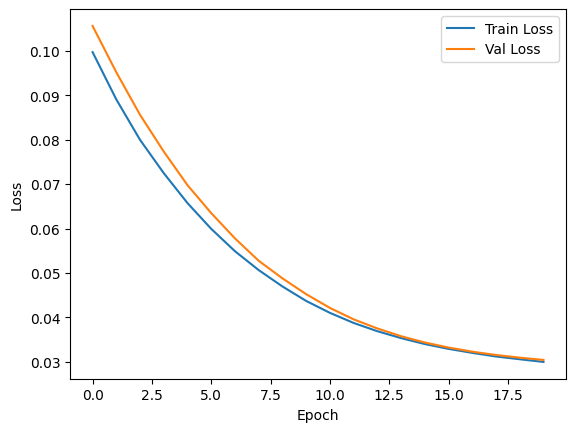

In [ ]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Hasil training model baseline menunjukkan penurunan yang konsisten pada training loss dan validation loss sepanjang 20 epoch. Training loss berkurang dari 0.1194 pada epoch pertama menjadi 0.0404 pada epoch terakhir, sementara validation loss juga menurun dari 0.1056 menjadi 0.0304. Ini menunjukkan bahwa model belajar dengan baik dari data pelatihan dan mampu generalisasi dengan cukup baik pada data validasi.

Tren penurunan ini mencerminkan bahwa model mengalami peningkatan kinerja seiring waktu, dengan perbaikan yang lebih signifikan di awal epoch dan sedikit melambat pada epoch terakhir. Model tampak mulai konvergen dan tidak mengalami overfitting yang signifikan, karena validation loss terus menurun bersama dengan training loss hingga akhir

## D. Model 2 Modification & Tuning

In [ ]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(window_size, x_train.shape[-1]))
    model_layers = layers.LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=False)(inputs)
    model_layers = layers.Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(model_layers)
    out = layers.Dense(1, activation="linear")(model_layers)
    model = Model(inputs=inputs, outputs=out)

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mean_squared_error'
    )
    return model

Pada model modifikasi, saya melakukan tuning hyperparameter untuk layer LSTM dengan menyesuaikan jumlah unit antara 32 hingga 128, tingkat dropout antara 0.1 hingga 0.5, dan learning rate dengan rentang dari 1e-5 hingga 1e-2. Proses tuning menggunakan Keras Tuner dengan Hyperband, dioptimalkan untuk meminimalkan validation loss dengan early_stopping sebagai callback untuk menghentikan pelatihan jika tidak ada peningkatan dalam 3 epoch berturut-turut.


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    directory='dir',
    project_name='lstm_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[early_stopping])


Trial 30 Complete [00h 01m 10s]
val_loss: 0.02983338199555874

Best val_loss So Far: 0.025341469794511795
Total elapsed time: 00h 19m 57s


In [ ]:
model_tuned = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

print("Best Hyperparameters:")
print(best_hp.values)


Best Hyperparameters:
{'units_1': 64, 'dropout': 0.2, 'learning_rate': 0.0008284768840933801, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


Hasil tuning menunjukkan hyperparameter terbaik yang ditemukan adalah 64 unit untuk layer LSTM, dropout 0.2, dan learning rate sebesar 0.00083. Dengan konfigurasi ini, model diharapkan dapat memberikan prediksi yang lebih akurat dengan mengurangi risiko overfitting dan meningkatkan konvergensi pelatihan.

In [ ]:
history2 = model_tuned.fit(train_ds, epochs=50, batch_size=32, validation_data=val_ds, initial_epoch=10)

Epoch 11/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0309 - val_loss: 0.0275
Epoch 12/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0297 - val_loss: 0.0279
Epoch 13/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0295 - val_loss: 0.0263
Epoch 14/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0296 - val_loss: 0.0296
Epoch 15/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0298 - val_loss: 0.0272
Epoch 16/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0292 - val_loss: 0.0292
Epoch 17/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0297 - val_loss: 0.0267
Epoch 18/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0290 - val_loss: 0.0306
Epoch 19/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0296 - val_loss: 0.0279
Epoch 20/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 21/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0296 - val_loss: 0.0281
Epoch 22/50
1260/1260

## E. Evaluasi

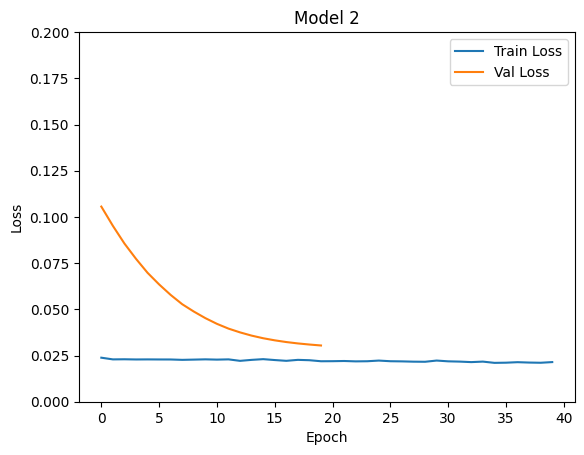

In [ ]:
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
plt.plot(train_loss2,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model 2")
plt.ylim(0, 0.2)
plt.show()

Hasil training menunjukkan fluktuasi yang relatif stabil pada training loss dan validation loss selama 50 epoch. Secara keseluruhan, nilai training loss menurun dari 0.0309 pada epoch 11 menjadi sekitar 0.0277 pada epoch 50, yang menunjukkan perbaikan dalam kemampuan model untuk memprediksi data pelatihan. Namun, validation loss mengalami beberapa variasi, mulai dari 0.0275 pada epoch 11, mencapai nilai terendah 0.0262 pada epoch 23, namun kemudian sedikit meningkat kembali di beberapa epoch terakhir.

Peningkatan validation loss yang tidak konsisten pada beberapa epoch menunjukkan bahwa model mulai mengalami sedikit overfitting pada data validasi setelah mencapai titik tertentu. Meskipun ada fluktuasi, model tetap menunjukkan kecenderungan untuk mempertahankan kinerja yang stabil pada data validasi, dengan validation loss yang bervariasi antara 0.0262 hingga 0.0307.


In [ ]:
y_pred = model.predict(test_ds)
y_pred = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
y_pred2 = model_tuned.predict(test_ds)
y_pred2 = scaler.inverse_transform(y_pred2)
y_test_inverse2 = scaler.inverse_transform(y_test.reshape(-1, 1))

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
mae = mean_absolute_error(y_test_inverse, y_pred)
mse = mean_squared_error(y_test_inverse, y_pred)
r2 = r2_score(y_test_inverse, y_pred)
print("Model Evaluation Results (Inverse Transformed):")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

Model Evaluation Results (Inverse Transformed):
MAE: 1.64491860543699
MSE: 4.679646871944126
R2: 0.7126065318177275


In [ ]:
mae2 = mean_absolute_error(y_test_inverse2, y_pred2)
mse2 = mean_squared_error(y_test_inverse2, y_pred2)
r22 = r2_score(y_test_inverse2, y_pred2)
print("Model Evaluation Results (Inverse Transformed):")
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R2: {r22}")

Model Evaluation Results (Inverse Transformed):
MAE: 0.5778871395789168
MSE: 0.7679701069139862
R2: 0.952836271939761


Hasil evaluasi model untuk baseline model menunjukkan nilai MAE sebesar 1.64, MSE sebesar 4.68, dan R2 sebesar 0.71. Nilai R2 yang sekitar 0.71 menunjukkan bahwa model mampu menjelaskan sekitar 71% variasi dalam data, namun masih terdapat ruang untuk perbaikan. MAE yang relatif tinggi mengindikasikan adanya perbedaan signifikan antara prediksi dan nilai aktual, sementara MSE yang cukup besar menunjukkan bahwa beberapa prediksi cukup jauh dari nilai sebenarnya.

Sebaliknya, hasil evaluasi untuk modified model (model 2) menunjukkan peningkatan performa yang signifikan. MAE turun menjadi 0.58, MSE turun menjadi 0.77, dan R2 meningkat drastis menjadi 0.95. Dengan nilai R2 yang mendekati 1, model ini berhasil menjelaskan sekitar 95% variasi dalam data, menunjukkan kemampuan model yang jauh lebih baik dalam generalisasi. Penurunan MAE dan MSE menandakan bahwa prediksi model lebih akurat dan mendekati nilai aktual. Secara keseluruhan, modifikasi model menghasilkan performa yang jauh lebih optimal dalam memprediksi data dibandingkan dengan baseline.